In [1]:
import ResonatorOptimizer as ro
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-deep')

In [2]:
# Global Parameters
__er = 11.9
__fo = 7.3e09
__h = 500e-06
__t = 50e-09
__pen_depth = 39e-09
__total_width = 80e-06
# __total_width_max = 100e-06
__length = 8102.64e-06
freq = np.linspace(2,12,30000)*1e09
# freq = np.linspace(7.1,7.3,2000)*1e09

__keyind = lambda X,X_array: min(enumerate(X_array), key=lambda x: abs(x[1]-X))

# Create Cavity Object

In [3]:
# cav_width, cav_gap, cav_length = [4e-06, 38e-06, 3502.64e-06]
cav_width, cav_gap, cav_length = [21.6e-06, 11.1e-06, 8102.64e-06]
lambda_cav = 2*cav_length
cavity = ro.cpwCalcs(cav_width,cav_gap,cav_length,__fo, __er, h=__h, t=__t, pen_depth=__pen_depth,wavelength=lambda_cav)
cav_f0 = 1 / (2 *cav_length* np.sqrt(cavity.capacitance_per_length() * cavity.Ltotal()))
cav_f0*1e-09

7.194232896093253

# Create Low Z Object

In [4]:
# lowZ_width, lowZ_gap, lowZ_length = [10e-06, 35e-06, 3516.64e-06]
lowZ_width, lowZ_gap, lowZ_length = [36.6e-06, 3.6e-06, 4091.32e-06]
lambda_lowZ = 4*lowZ_length
lowZ = ro.cpwCalcs(lowZ_width,lowZ_gap,lowZ_length,__fo, __er, h=__h, t=__t, pen_depth=__pen_depth,wavelength=lambda_lowZ)
low_f0 = 1 / (4 * lowZ_length* np.sqrt(lowZ.capacitance_per_length() * lowZ.Ltotal() ) )
low_f0*1e-09

7.193114258877974

# Create High Z Object

In [5]:
# highZ_width, highZ_gap, highZ_length = [10e-06, 35e-06, 3516.64e-06]
highZ_width, highZ_gap, highZ_length = [7.8e-06, 18e-06, 3566.32e-06]
lambda_highZ = 4*lowZ_length
highZ = ro.cpwCalcs(highZ_width,highZ_gap,highZ_length,__fo, __er, h=__h, t=__t, pen_depth=__pen_depth,wavelength=lambda_highZ)
high_f0 = 1 / (4 * highZ_length* np.sqrt(highZ.capacitance_per_length() * highZ.Ltotal() ) )
high_f0*1e-09

7.198469921896215

# Get ABCD matrices

In [6]:
def get_abcd(cpw,freq,length):
    gamma = cpw.gamma(freq,tan_d=10)
    Z0 = cpw.impedance_kinetic()

    sp = ro.Sparams(freq=freq,gamma=gamma,length=length,Z0=Z0)
    abcd = sp.transmission()
    return abcd

In [7]:
cav_abcd = get_abcd(cavity,freq,cav_length)
lowZ_abcd = get_abcd(lowZ,freq,lowZ_length)
highZ_abcd = get_abcd(highZ,freq,highZ_length)

# Define Bragg Geometry

In [8]:
mirror_lhs = [np.matmul(lowZ_abcd[i], highZ_abcd[i]) for i in range(len(freq))]
mirror_rhs = [np.matmul(highZ_abcd[i], lowZ_abcd[i]) for i in range(len(freq))]
bragg = [np.matmul(mirror_lhs[i]**5, np.matmul(cav_abcd[i], mirror_rhs[i]**5)) for i in range(len(freq))]

# mirror_lhs = [lowZ_abcd[i] * highZ_abcd[i] * lowZ_abcd[i] * highZ_abcd[i] * lowZ_abcd[i] * highZ_abcd[i] * lowZ_abcd[i] * highZ_abcd[i] for i in range(len(freq))]
# mirror_rhs = [highZ_abcd[i] * lowZ_abcd[i] * highZ_abcd[i] * lowZ_abcd[i] * highZ_abcd[i] * lowZ_abcd[i] * highZ_abcd[i] * lowZ_abcd[i] * highZ_abcd[i] * lowZ_abcd[i] for i in range(len(freq))]
# bragg = [mirror_lhs[i] * cav_abcd[i] * mirror_rhs[i] for i in range(len(freq))]

sp = ro.Sparams(freq=freq)
bragg_s21 = sp.s21_from_abcd(bragg)

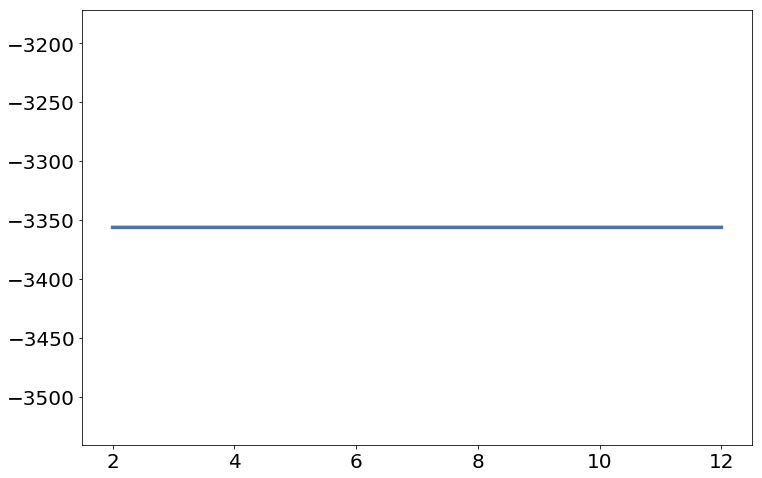

In [9]:
plt.figure(figsize=(12,8))
plt.plot(freq*1e-09,bragg_s21.real)
# plt.ylim(-100,40)
plt.show()